#Bird Localization#
In this project we are going to use a dataset full of bird images. all of the images are birds in 200 classes but we know those are bird and there is Bounding box labels inside the dataset, so this Dataset is suitable just for Object Localization. we are going to use Transfer Learning, so all of the images should be in 224 ⋆ 224 shape. **There is a lot of Functions imported from the Assignment file. The main point of this project is not about writing visualizition and utilization functions.

#Imports

In [ ]:
import tensorflow as tf
import os, time, re, json
import numpy as np
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


#Data

##pre-Process & Save dataset##
**[ Not necessary to run these cells in later runs ]**

In [ ]:
data_path = '/content/drive/My Drive/TF3 C3 W1 Data/'

In [ ]:
trainData, info = tfds.load('caltech_birds2010',
                            split='train', download=True, data_dir = data_path, with_info=True)

In [ ]:
testData, info = tfds.load('caltech_birds2010',
                           split='test', download=True, data_dir = data_path, with_info=True)

In [ ]:
def get_data(data):
  bboxes = []
  images =[]
  for dicts in data:
    image = dicts['image']
    image = tf.cast(image, tf.float32)
    x = tf.cast(image.shape[0], tf.float32)
    y = tf.cast(image.shape[1], tf.float32)
    bbox= dicts['bbox']
    bbox = [bbox[0] * x,
            bbox[1] * y,
            bbox[2] *x,
            bbox[3] *y]
    bboxes.append(bbox)
    images.append(image)
  return np.array(bboxes), np.array(images)

In [ ]:
def normalizer(images):
  final = []
  for i in range(len(images)):
    images[i] = np.array(((tf.image.resize(images[i], (224, 224))) / 127.5) - 1)
    # images[i] /= 127.5
    # images[i] -= 1
    # images[i] = np.array(images[i])
    final.append(images[i])
  return np.array(final)

In [ ]:
def get_data(data): #for the final_testImages
  bboxes = []
  images =[]
  for dicts in data:
    image = dicts['image']
    image = tf.cast(image, tf.float32)
    x = tf.cast(image.shape[0], tf.float32)
    y = tf.cast(image.shape[1], tf.float32)
    bbox= dicts['bbox']
    bbox = [bbox[0] * x,
            bbox[1] * y,
            bbox[2] *x,
            bbox[3] *y]
    bboxes.append(bbox)
    image = (image/ 127.5)-1
    images.append(image)
  return np.array(bboxes), np.array(images)

In [ ]:
final_testData, info = tfds.load('caltech_birds2010',
                           split='test', download=True, data_dir = data_path, with_info=True)
final_testBboxes , final_testImages = get_data(final_testData)

In [ ]:
trainBboxes , trainImages = get_data(trainData)
trainImages = normalizer(trainImages)
testBboxes , testImages = get_data(testData)
testImages = normalizer(testImages)


<ipython-input-6-c1df7d0b85d1>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(bboxes), np.array(images)


In [ ]:
np.save('/content/drive/MyDrive/birds/'+'trainImages.npy',trainImages)
np.save('/content/drive/MyDrive/birds/'+'trainBboxes.npy',trainBboxes)
np.save('/content/drive/MyDrive/birds/'+'testImages.npy',testImages)
np.save('/content/drive/MyDrive/birds/'+'testBboxes.npy',testBboxes)

##Load Pre-Processed Data##

In [ ]:
#@title Numpy Mode (on cpu memory)
trainImages = np.load('/content/drive/MyDrive/birds/'+'trainImages.npy')
trainBboxes = np.load('/content/drive/MyDrive/birds/'+'trainBboxes.npy')
testImages = np.load('/content/drive/MyDrive/birds/'+'testImages.npy')
testBboxes = np.load('/content/drive/MyDrive/birds/'+'testBboxes.npy')

In [ ]:
#@title [Run me]
final_testImages = np.load('/content/drive/MyDrive/birds/final_testImages.npy' ,allow_pickle=True)

In [ ]:
#@title tensorflow mode (on gpu memory) [run me]

import tensorflow as tf

# Define file paths
train_images_path = '/content/drive/MyDrive/birds/trainImages.npy'
train_bboxes_path = '/content/drive/MyDrive/birds/trainBboxes.npy'
test_images_path = '/content/drive/MyDrive/birds/testImages.npy'
test_bboxes_path = '/content/drive/MyDrive/birds/testBboxes.npy'

# Load data into TensorFlow variables
trainImages = tf.constant(np.load(train_images_path))
trainBboxes = tf.constant(np.load(train_bboxes_path))
testImages = tf.constant(np.load(test_images_path))
testBboxes = tf.constant(np.load(test_bboxes_path))


In [ ]:
print(trainImages[45].shape[0], trainImages[45].shape[1], trainImages[45].shape[2],
      trainBboxes[45][0], trainBboxes[45][1], trainBboxes[45][2], trainBboxes[45][3])

224 224 3 tf.Tensor(117.0, shape=(), dtype=float32) tf.Tensor(96.0, shape=(), dtype=float32) tf.Tensor(331.0, shape=(), dtype=float32) tf.Tensor(341.0, shape=(), dtype=float32)


In [ ]:
#@title Create TensorFlow datasets [no need to run]
'''
train_dataset = tf.data.Dataset.from_tensor_slices((trainImages, trainBboxes))
test_dataset = tf.data.Dataset.from_tensor_slices((testImages, testBboxes))

# Optionally, apply further transformations or augmentations to the datasets
# For example:
# train_dataset = train_dataset.map(your_preprocessing_function)
# test_dataset = test_dataset.map(your_preprocessing_function)

# Batch the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Prefetch the datasets for better performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
'''

#Model#

##Define & Compile Model##

In [ ]:
#@title Model Architecture
def feature_extractor(input):
  mobileNet = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False, weights='imagenet' )
  mobileNet.trainable = False
  features = mobileNet(input)
  return features
def custom_layers(input):
  x = tf.keras.layers.GlobalAveragePooling2D()(input)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dense(512, activation = 'relu')(x)
  return x
def boundingBox_regression(input):
  output = tf.keras.layers.Dense(4, name='boundinBox_regression')(input)
  return output

def final_model(input):
  feature_ext = feature_extractor(input)
  layers = custom_layers(feature_ext)
  boundingBox = boundingBox_regression(layers)
  model = tf.keras.models.Model(inputs = input, outputs= boundingBox )
  return model
def compilerAndFinisher():
  input = tf.keras.layers.Input(shape=(224, 224, 3))
  model = final_model(input)
  model.compile(optimizer= 'adam', loss= 'mse', metrics='accuracy')
  return model


In [ ]:
model = compilerAndFinisher()
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                

##Run the Model##

In [ ]:
def data_generator(images, bboxes, batch_size):
    while True:
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i + batch_size]
            batch_bboxes = bboxes[i:i + batch_size]
            yield batch_images, batch_bboxes

generator = data_generator(trainImages, trainBboxes, batch_size=8)
history = model.fit(generator, epochs=25, steps_per_epoch=len(trainImages) // 8, validation_data=(testImages, testBboxes))


Epoch 1/25
375/375 [==============================] - 27s 40ms/step - loss: 7482.3413 - accuracy: 0.6640 - val_loss: 4755.5215 - val_accuracy: 0.6686
Epoch 2/25
375/375 [==============================] - 13s 33ms/step - loss: 4349.4580 - accuracy: 0.6980 - val_loss: 4393.5620 - val_accuracy: 0.7079
Epoch 3/25
375/375 [==============================] - 11s 29ms/step - loss: 3772.2747 - accuracy: 0.7253 - val_loss: 4239.3428 - val_accuracy: 0.7244
Epoch 4/25
375/375 [==============================] - 10s 28ms/step - loss: 3380.1184 - accuracy: 0.7547 - val_loss: 4179.3984 - val_accuracy: 0.7197
Epoch 5/25
375/375 [==============================] - 12s 31ms/step - loss: 3045.3916 - accuracy: 0.7773 - val_loss: 4179.2261 - val_accuracy: 0.7221
Epoch 6/25
375/375 [==============================] - 11s 30ms/step - loss: 2729.9407 - accuracy: 0.7980 - val_loss: 4204.3809 - val_accuracy: 0.7250
Epoch 7/25
375/375 [==============================] - 12s 32ms/step - loss: 2417.8325 - accuracy: 0.

#Metrics#

In [ ]:
pred_set = testImages[0:20]

In [ ]:
predicted = model.predict(pred_set, batch_size=8)

3/3 [==============================] - 1s 169ms/step


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 5 + 1), history.history['val_loss'], color='b')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.ylim([0, 1])  # Set y-axis limit between 0 and 1
plt.grid(True)
plt.show()

In [ ]:
np.save('/content/drive/MyDrive/birds/'+'final_testImages.npy',final_testImages[0:20])

10


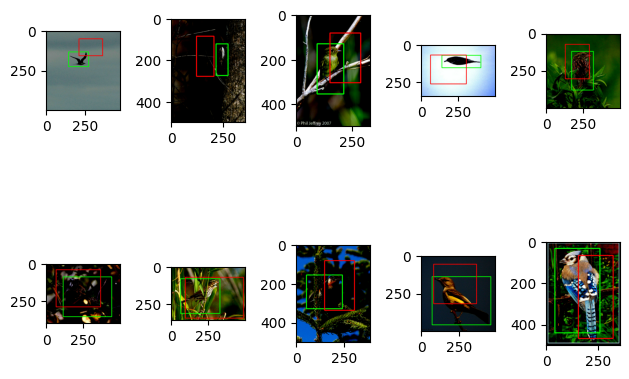

In [ ]:
index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
images = []
for i in index:
  current = ((np.asarray(final_testImages[i]).astype(np.float32))/127.5)-1
  image = cv2.rectangle(current, (int(testBboxes[i][1]), int(testBboxes[i][0])),
   (int(testBboxes[i][3]), int(testBboxes[i][2])), (0, 255, 0), 3)
  image = cv2.rectangle(image, (int(predicted[i][1]), int(predicted[i][0])),
   (int(predicted[i][3]), int(predicted[i][2])), (255,0, 0), 4)
  images.append(image)
figure , axes = plt.subplots(2,5)
print(len(images))
for i in range(len(images)):
  ax_row = i//5

  ax_col = i% 5
  if ax_row ==2 or ax_col==5:
    break
  ax = axes[ax_row][ax_col]
  ax.imshow(images[i], cmap='hot')
  ax.axis ='off'
plt.tight_layout()
plt.show()

###😞 should modify it again###
results are awful.

In [ ]:
np.max(final_testImages[1])

211.0

#was for test and now useless (TRASH)#

In [ ]:
print(np.max(trainBboxes[1]))
print(trainBboxes[1])
bboxw = trainBboxes[1]
# for dict in trainData:
#   shape = dict['image'].shape
# print(shape[1], shape[0])

433.0
tf.Tensor([ 98.  98. 433. 245.], shape=(4,), dtype=float32)


In [ ]:
print(trainImages[45].shape[0], trainImages[45].shape[1], trainImages[45].shape[2],
      trainBboxes[45][0], trainBboxes[45][1], trainBboxes[45][2], trainBboxes[45][3])

224 224 3 tf.Tensor(117.0, shape=(), dtype=float32) tf.Tensor(96.0, shape=(), dtype=float32) tf.Tensor(331.0, shape=(), dtype=float32) tf.Tensor(341.0, shape=(), dtype=float32)


In [ ]:
type(trainImagesNormal[21])

NameError: ignored

In [ ]:
im = np.array(trainImagesNormal[21])
type(im)

numpy.ndarray

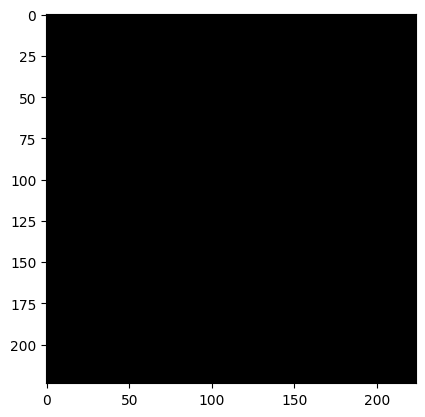

In [ ]:
plt.imshow(trainImagesNormal[1])

In [ ]:
image = cv2.rectangle(trainImages[45], (int(trainBboxes[45][1]), int(trainBboxes[45][0])), (int(trainBboxes[45][3]), int(trainBboxes[45][2])) ,(255, 0, 0) , 5)


error: ignored

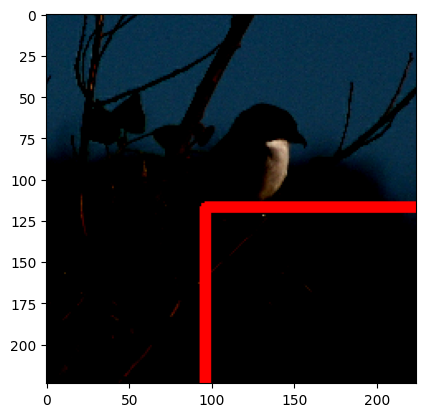

In [ ]:
plt.imshow(image)

In [ ]:
np.max(testImages[867])

0.97099864

In [ ]:
print(testImages.shape, testBboxes.shape)

(3033, 224, 224, 3) (3033, 4)
